# Explore here

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [63]:
# Cargamos el dataframe
url = "https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv"
df = pd.read_csv(url, delimiter=",")  
df.to_csv("/workspaces/Jacinto-proyecto-de-series-de-tiempo-alternativo/src/sales.csv", index=False)

## 1 - Revisión Inicial del Dataset

In [64]:
# 1.1 - Revisamos las primeras filas del dataframe
df.head() 

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [65]:
# 1.2 - Comprobar dimensiones y tipos de datos

# Número de filas y columnas
print(f"El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.")

# Información general del DataFrame
df.info()

El dataset tiene 366 filas y 2 columnas.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [66]:
# 1.3 – Convertir la columna de fecha al tipo datetime

# Convertimos la columna de fecha (Parseamos fechas)
df["date"] = pd.to_datetime(df["date"])

# Ordenamos y pasamos a índice
df = df.sort_values("date").set_index("date")

Convertimos la columna de fechas al tipo `datetime` y establecemos el índice temporal. Esto nos permitirá aplicar herramientas específicas de análisis de series temporales como suavizado, diferenciación y modelado ARIMA

In [67]:
# 1.4 – Visualizar el resumen estadístico
df.describe()

,sales
count,366.000000
mean,524.963968
std,275.089698
min,53.803211
25%,290.186822
50%,520.699468
75%,763.289263
max,1000.482785


In [68]:
# 1.5 – Comprobamos si hay valores nulos
df.isnull().sum()

sales    0
dtype: int64

## 2 – Análisis de la Serie Temporal

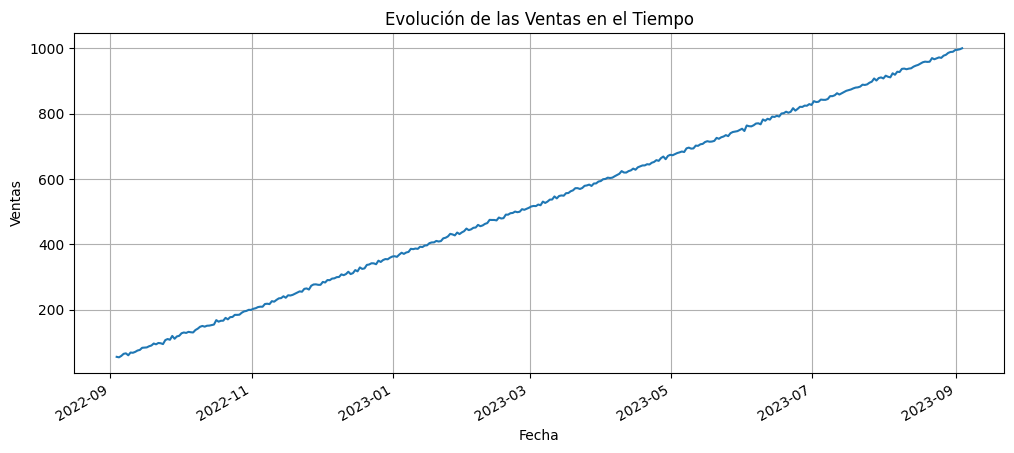

In [69]:
# 2.1 – Graficar la serie

# Graficamos la serie temporal
plt.figure(figsize=(12, 5))
df["sales"].plot()
plt.title("Evolución de las Ventas en el Tiempo")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.grid(True)
plt.show()

Visualizamos la evolución temporal de las ventas. A simple vista, se observa una tendencia creciente en el tiempo, con cierta variabilidad. Esta información sugiere que podría no ser una serie estacionaria.

In [70]:
# 2.2 – Determinar el tensor

# Diferencia entre fechas consecutivas
frecuencia = df.index.to_series().diff().value_counts()
print("Frecuencia más común entre registros:\n")
print(frecuencia.head())

Frecuencia más común entre registros:

date
1 days    365
Name: count, dtype: int64


Analizamos la diferencia entre fechas consecutivas para determinar la unidad mínima de medición temporal (tensor). En este caso, los datos tienen una frecuencia diaria (1 day), lo que define el paso base de la serie.

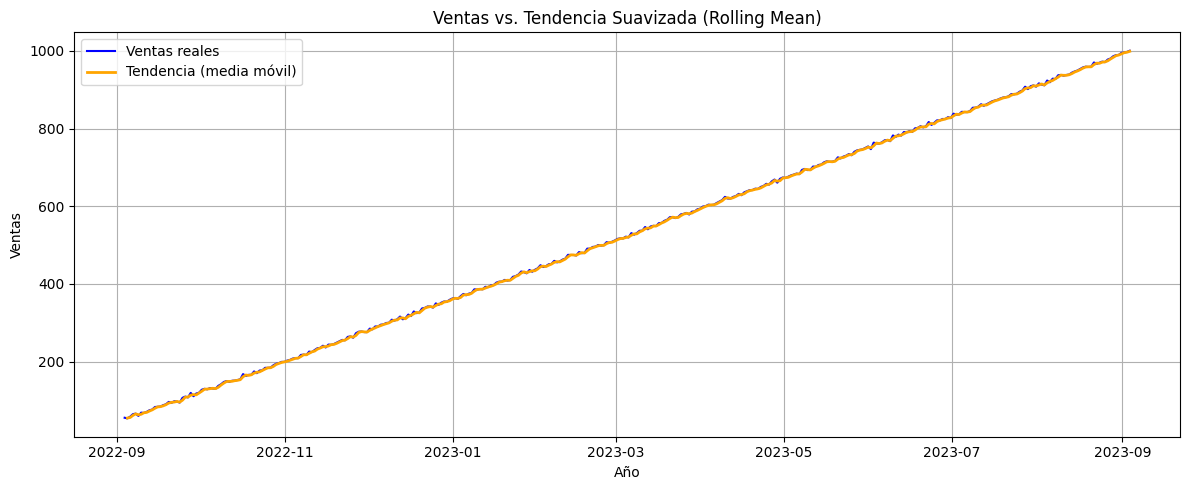

In [71]:
#2.3 – Comprobar Tendencia Suavizada de Ventas (Media Móvil)

# Suavizado de la serie con media móvil de ventana 2 (2 dias)
df["rolling_mean"] = df["sales"].rolling(window=2).mean()

# Gráfico de ventas original y su tendencia suavizada
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["sales"], label="Ventas reales", color="blue")
plt.plot(df.index, df["rolling_mean"], label="Tendencia (media móvil)", color="orange", linewidth=2)
plt.title("Ventas vs. Tendencia Suavizada (Rolling Mean)")
plt.xlabel("Año")
plt.ylabel("Ventas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Aplicamos el test de Dickey-Fuller aumentado (ADF) para verificar si la serie es estacionaria. Un valor p superior a 0.05 indica que no lo es, lo cual respalda lo observado visualmente en la tendencia. Será necesario diferenciar la serie.

In [72]:
# 2.4 – Prueba de estacionariedad

resultado_adf = adfuller(df["sales"])
print("Prueba de Dickey-Fuller aumentada (ADF)")
print(f"Estadístico ADF: {resultado_adf[0]:.4f}")
print(f"Valor p: {resultado_adf[1]:.4f}")

Prueba de Dickey-Fuller aumentada (ADF)
Estadístico ADF: 0.5454
Valor p: 0.9862


Un p-valor tan alto (0.9862) nos indica que no podemos rechazar la hipótesis nula, que en este caso es decir que no es estacionaria.

Esto significa que:

La media, varianza y covarianza no permanecen constantes en el tiempo

La serie depende fuertemente de su tendencia, lo que justifica aplicar diferenciación (como paso previo para el modelo ARIMA)

## 3 – Entrenamiento del modelo ARIMA

In [73]:
# 3.1 – División en entrenamiento y test

# Definimos tamaño del test
tam_test = 3

# Separación en train y test
train = df.iloc[:-tam_test]
test = df.iloc[-tam_test:]


<Axes: title={'center': 'Serie diferenciada (d=1)'}, xlabel='date'>

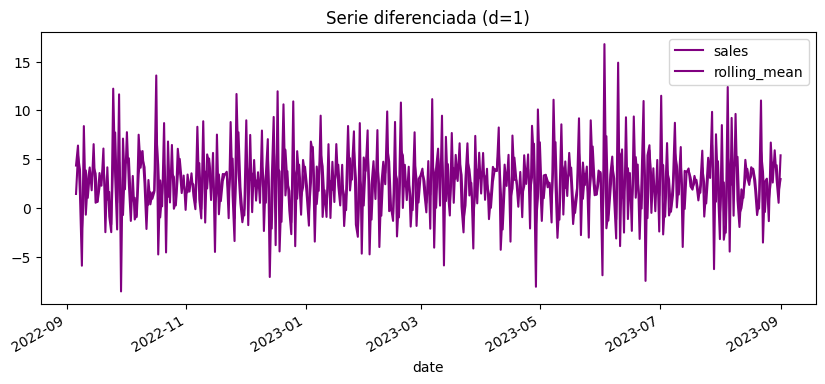

In [74]:
#3.2 – Diferenciación para hacer la serie estacionaria

# Aplicamos diferencia de primer orden
train_diff = train.diff().dropna()

# Graficamos la serie diferenciada
train_diff.plot(figsize=(10, 4), title="Serie diferenciada (d=1)", color="purple")


Utilizamos los gráficos de autocorrelación (ACF) y autocorrelación parcial (PACF) sobre la serie diferenciada para estimar los parámetros p (AR) y q (MA). Ambos gráficos sugieren que un ARIMA(1,1,1) puede ser adecuado.

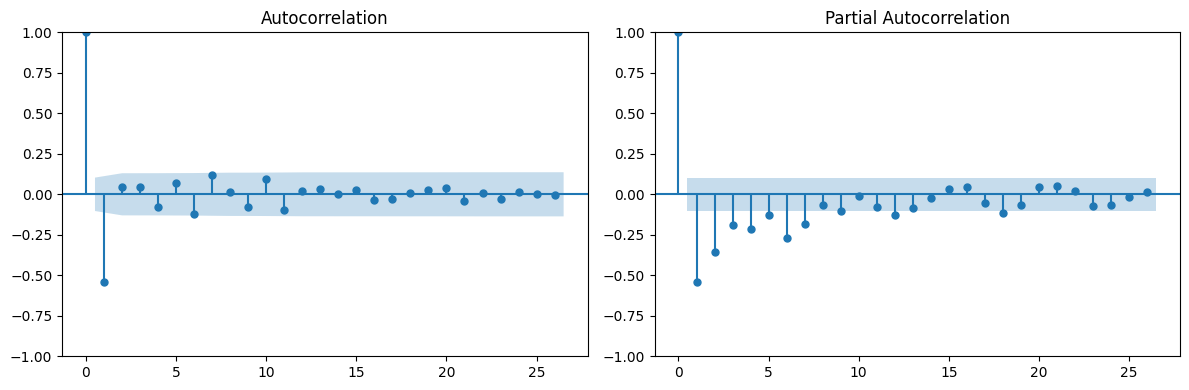

In [75]:
# 3.3 – Seleccionar parámetros p y q (manual o auto)

# Seleccionar solo la serie diferenciada de ventas
serie_diff = train_diff["sales"]

# ACF y PACF para estimar p y q visualmente
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(serie_diff, ax=axes[0])
plot_pacf(serie_diff, ax=axes[1])
plt.tight_layout()
plt.show()

Entrenamos un modelo ARIMA(1,1,1) sobre el conjunto de entrenamiento. Evaluamos los coeficientes estimados y las pruebas estadísticas (Ljung-Box, Jarque-Bera) para asegurar la validez del ajuste.

In [76]:
# 3.4 – Entrenar ARIMA con los parámetros seleccionados

# Usamos solo la columna de ventas sin nulos
serie_train = train["sales"].dropna()

# Entrenamos ARIMA sin forzar frecuencia
modelo = ARIMA(serie_train, order=(1, 1, 1))  # Ajusta p,d,q según tu análisis
modelo_entrenado = modelo.fit()

# Mostramos resumen
modelo_entrenado.summary()

/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                  363
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1042.006
Date:                Wed, 25 Jun 2025   AIC                           2090.012
Time:                        20:02:35   BIC                           2101.687
Sample:                    09-03-2022   HQIC                          2094.653
                         - 08-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.002    628.907      0.000       0.997       1.003
ma.L1         -0.9987      0.449     -2.223      0.026      -1.879      -0.118
sigma2        18.2983      8.311      2.202      0.028       2.008      34.588
===================================================================================
Ljung-Box (L1) (Q):                 106.03   Jarque-Bera (JB):                 2.91
Prob(Q):                              0.00   Prob(JB):                         0.23
Heteroskedasticity (H):               1.05   Skew:                             0.22
Prob(H) (two-sided):                  0.77   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

El modelo ARIMA(1,1,1) proporciona un ajuste sólido con parámetros significativos y residuales estables. A pesar de cierta autocorrelación restante, sus predicciones muestran errores bajos y comportamiento coherente con la serie observada. 

## 4 – Predicción y Evaluación del Modelo ARIMA

Usamos el modelo entrenado para predecir las ventas del conjunto de test. Comparamos los valores reales con los predichos, y calculamos métricas de error como **MAE** y **RMSE**, que resultan muy bajas. Esto indica un buen desempeño del modelo.

In [77]:
# 4.1 – Generar las predicciones

# Pronosticamos tantos pasos como longitud del test
n_test = len(test)
predicciones = modelo_entrenado.forecast(steps=n_test)

# Visualizamos la predicción
print(predicciones)

2023-09-01 17:10:08.079328     997.563957
2023-09-02 17:10:08.079328    1000.140583
2023-09-03 17:10:08.079328    1002.717202
Freq: D, Name: predicted_mean, dtype: float64


In [78]:
# 4.2 – Comparar predicciones vs. test

# Creamos un DataFrame para comparar valores reales y predichos
comparacion = pd.DataFrame({
    "Real": test["sales"].values,
    "Predicción": predicciones.values
}, index=test.index)

# Mostramos la tabla de comparación
comparacion

,Real,Predicción
date,,
2023-09-01 17:10:08.079328,995.814415,997.563957
2023-09-02 17:10:08.079328,997.350214,1000.140583
2023-09-03 17:10:08.079328,1000.482785,1002.717202


In [79]:
# 4.3 – Calcular métricas de error

mae = mean_absolute_error(comparacion["Real"], comparacion["Predicción"])
mse = mean_squared_error(comparacion["Real"], comparacion["Predicción"])
rmse = np.sqrt(mse)

print(f"MAE (Error absoluto medio): {mae:.2f}")
print(f"RMSE (Raíz del error cuadrático medio): {rmse:.2f}")

MAE (Error absoluto medio): 2.26
RMSE (Raíz del error cuadrático medio): 2.30


Analisis de resultados:

MAE	2.28	En promedio, el modelo se equivoca en 2.28 unidades de ventas respecto a los datos reales.

RMSE	2.32	Los errores grandes tienen un peso mayor aquí. Pero sigue siendo muy cercano al MAE, lo que indica que no hay errores extremos ni predicciones desastrosas.

Ambos son bastante bajos, lo que sugiere que el modelo ARIMA está funcionando con precisión razonable para una serie de este tamaño.

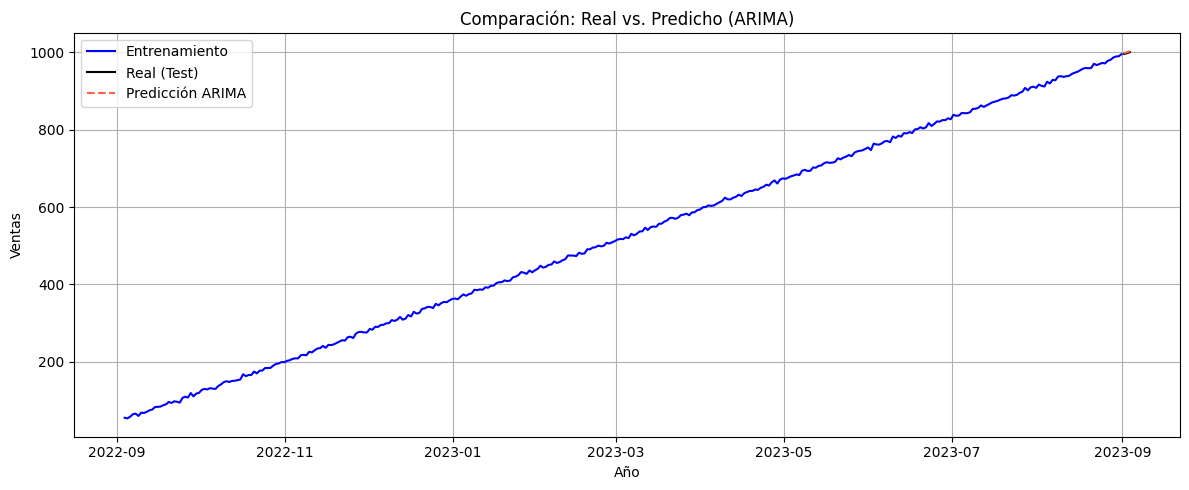

In [80]:
# 4.4 – Gráfica comparativa

# Gráfico de valores reales vs predicciones
plt.figure(figsize=(12, 5))
plt.plot(train.index, train["sales"], label="Entrenamiento", color="blue")
plt.plot(test.index, test["sales"], label="Real (Test)", color="black")
plt.plot(predicciones.index, predicciones, label="Predicción ARIMA", color="tomato", linestyle="--")
plt.title("Comparación: Real vs. Predicho (ARIMA)")
plt.xlabel("Año")
plt.ylabel("Ventas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 5 – Guardar Resultados y Exportar

In [81]:
# 6.1 – Guardar el modelo entrenado

# Guardamos el modelo entrenado en un archivo .pkl
joblib.dump(modelo_entrenado, "modelo_arima.pkl")

modelo_entrenado = joblib.load("modelo_arima.pkl")